# Using Age, Cholestorol Levels, and Blood Pressure to assess prognosis of heart disease.

Ethan D'Souza, Emily Zhang, Alice An, Vivaan Wadhwa

# 1. Introduction

Heart disease is a common cause of death between all groups of people in the United States. Both genetic and environmental circumstances can contribute to the possibility of developing the condition. 

Multiple risk factors affect the likelihood of heart disease such as age, blood pressure, cholesterol. Older people are more likely to be diagnosed with heart disease (Rogers et al., 2019). According to the CDC, high cholesterol levels lead to plaque formation in blood vessels which makes them less flexible and narrower. Leading to the inability of blood to circulate around the body, irregular heart beats and ultimately, death. Furthermore, high blood pressure causes arteries to lose their elasticity which in turn leads to lower blood circulation to the heart.

Ultimately, our goal is to answer the question “is a person likely to have heart disease based on their age, resting blood pressure, and cholesterol?”

# 2. Preliminary Data Analysis

For starters, we load the necessary packages needed to perform the analysis. 

In [19]:
library(repr)
library(tidyverse)
library(tidymodels)

The data is first loaded from the web. We tidied the data, and renamed the columns for better readability. We ended up with a final tibble containing the four variables that are relevant to our question. Here, likelihood is our classification variable with type “factor”, and age, resting blood pressure, and cholesterol are predictor variables all with type “double”. 

In [21]:
raw_data_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
raw_data <- read_csv(raw_data_url,col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs","restecg", "thalach", "exang" ,"oldpeak" ,"slope" ,"ca" ,"thal" ,"num"))
tidy_data <- raw_data |>
                select(age,trestbps,chol,num) |>
                    rename("age" = "age",
                           "resting.blood.pressure" = "trestbps" ,
                           "cholesterol" = "chol",
                           "likelihood" = "num") |>
                    mutate(likelihood = case_when(likelihood == 0 ~ "Absent",
                                                  likelihood != 0 ~ "Present")) |>
                    mutate(likelihood = as.factor(likelihood))
head(tidy_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age resting.blood.pressure cholesterol likelihood
1   63  145                    233         Absent    
2   67  160                    286         Present   
3   67  120                    229         Present   
4   37  130                    250         Absent    
5   41  130                    204         Absent    
6   56  120                    236         Absent    
7   62  140                    268         Present   
8   57  120                    354         Absent    
9   63  130                    254         Present   
10  53  140                    203         Present   
11  57  140                    192         Absent    
12  56  140                    294         Absent    
13  56  130                    256         Present   
14  44  120                    263         Absent    
15  52  172                    199         Absent    
16  57  150                    168         Absent    
17  48  110                    229         Present   
18  54  140                    239         Absent    
19  48  130                    275         Absent    
20  49  130                    266         Absent    
21  64  110                    211         Absent    
22  58  150                    283         Absent    
23  58  120                    284         Present   
24  58  132                    224         Present   
25  60  130                    206         Present   
26  50  120                    219         Absent    
27  58  120                    340         Absent    
28  66  150                    226         Absent    
29  43  150                    247         Absent    
30  40  110                    167         Present   
⋮   ⋮   ⋮                      ⋮           ⋮         
274 71  112                    149         Absent    
275 59  134                    204         Present   
276 64  170                    227         Absent    
277 66  146                    278         Absent    
278 39  138                    220         Absent    
279 57  154                    232         Present   
280 58  130                    197         Absent    
281 57  110                    335         Present   
282 47  130                    253         Absent    
283 55  128                    205         Present   
284 35  122                    192         Absent    
285 61  148                    203         Present   
286 58  114                    318         Present   
287 58  170                    225         Present   
288 58  125                    220         Absent    
289 56  130                    221         Absent    
290 56  120                    240         Absent    
291 67  152                    212         Present   
292 55  132                    342         Absent    
293 44  120                    169         Present   
294 63  140                    187         Present   
295 63  124                    197         Present   
296 41  120                    157         Absent    
297 59  164                    176         Present   
298 57  140                    241         Present   
299 45  110                    264         Present   
300 68  144                    193         Present   
301 57  130                    131         Present   
302 57  130                    236         Present   
303 38  138                    175         Absent

We set the seed so that all the code below is reproducible. The data is then split into 75% training data, and 25% testing data. Only the training data will be used in our analysis. 

In [16]:
set.seed(1) ## DO NOT CHANGE

## splitting into training and testing data
data_split <- initial_split(tidy_data, prop = 0.75, strata = likelihood)
data_train <- training(data_split)
data_test <- testing(data_split)

The data is summarized into three tables: 
- number of observations of “present” and "absent"
- average values of all predictors for observations with "absent"
- average values of all predictors for observations with "present".

In [17]:
##Number of observations of "present" and "absent"
data_count <- data_train |> 
        group_by(likelihood) |>
        summarize(count = n())
data_count

likelihood count
1 Absent     123  
2 Present    104

In [18]:
##Average Values of all predictors for observations with "absent"

data_absent_mean <- data_train |>
        filter(likelihood == "Absent") |>
        summarize(across(age:cholesterol, mean)) |>
         rename("mean.age" = "age",
                           "mean.resting.blood.pressure" = "resting.blood.pressure" ,
                           "mean.cholesterol" = "cholesterol") 

data_absent_mean

mean.age mean.resting.blood.pressure mean.cholesterol
1 52.96748 130.4553                    243.9106

In [19]:
##Average Values of all predictors for observations with "present"
data_present_mean <- data_train |>
        filter(likelihood == "Present") |>
        summarize(across(age:cholesterol, mean)) |>
         rename("mean.age" = "age",
                           "mean.resting.blood.pressure" = "resting.blood.pressure" ,
                           "mean.cholesterol" = "cholesterol")

data_present_mean

mean.age mean.resting.blood.pressure mean.cholesterol
1 57.23077 135.5096                    250.5673

## Visualizations

Created a scatterplot of Resting Blood Pressure in mm of Mercury(Hg) against Age of the patient, coloured by likelihood. After age 50 there seems to be more individuals with heart disease present than without and the average Resting Blood Pressure increases.  

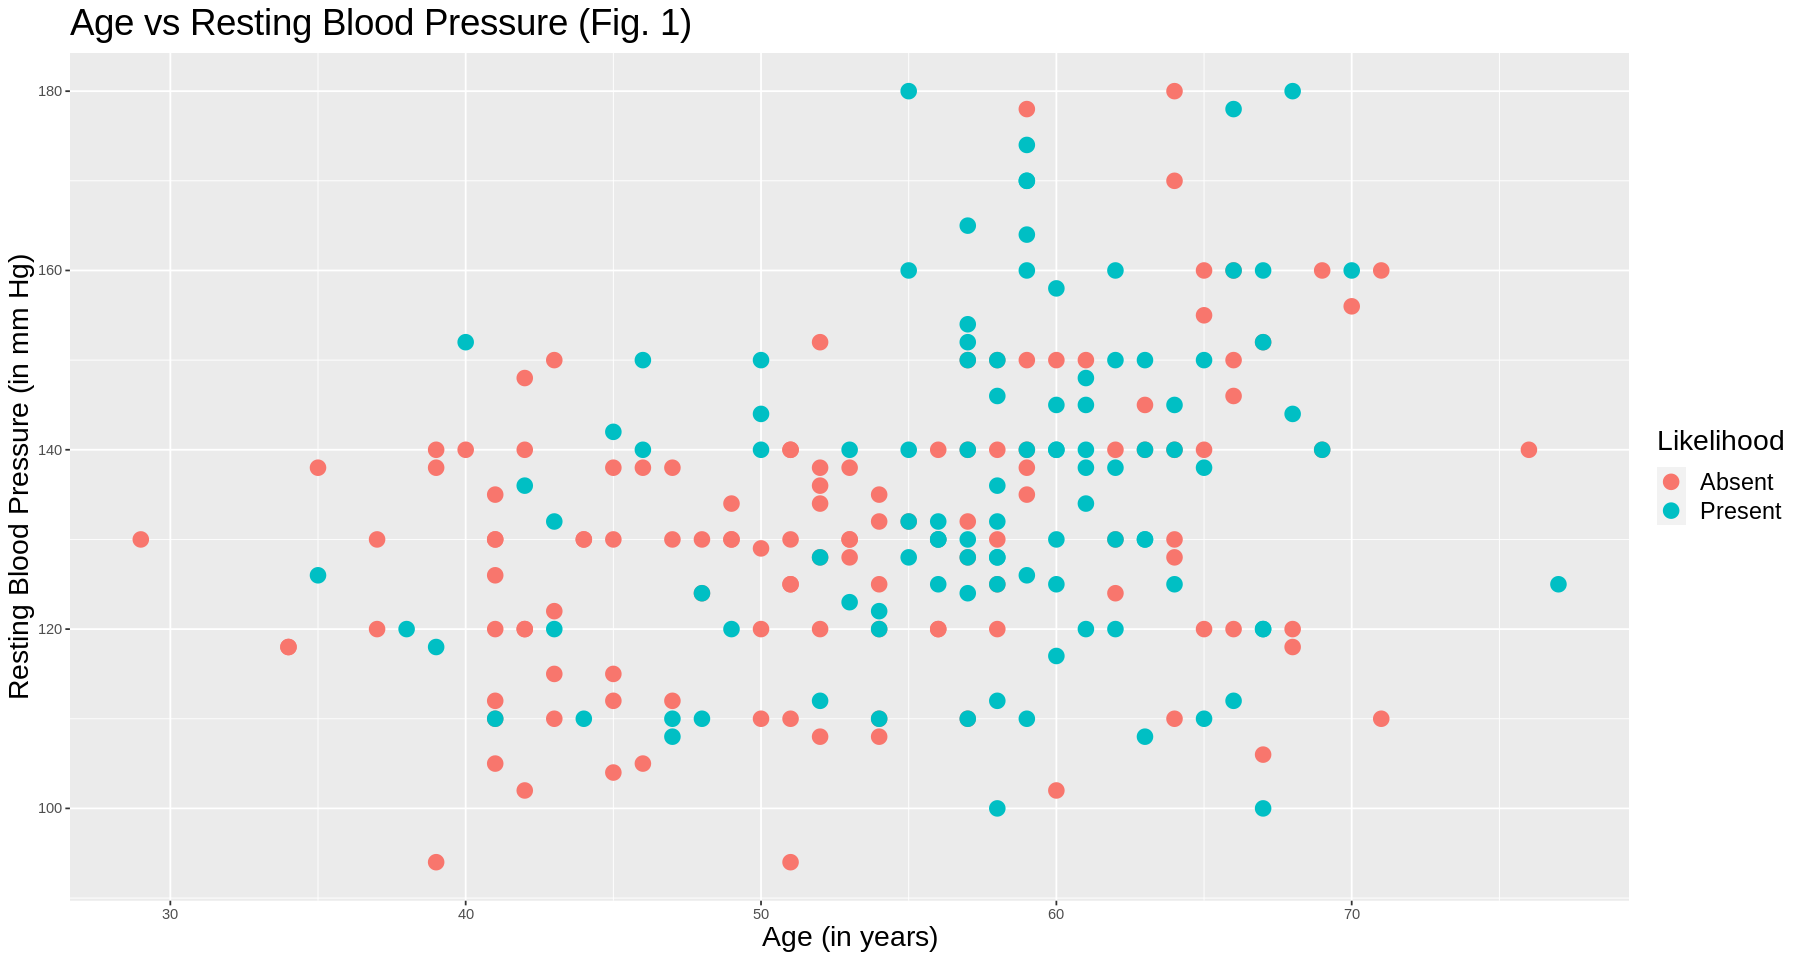

In [20]:
##Age vs Blood Pressure, coloured by likelihood

options(repr.plot.width=15, repr.plot.height=8)
age_v_bp_plot <- data_train |>
                ggplot(aes(x = age, y = resting.blood.pressure, color = likelihood)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Resting Blood Pressure (in mm Hg)") +
                labs(color = "Likelihood", shape = "Likelihood") +
                ggtitle("Age vs Resting Blood Pressure (Fig. 1)") + 
                theme(plot.title = element_text(size=22),
                      axis.title = element_text(size=17),
                      legend.title = element_text(size = 17),
                      legend.text = element_text(size = 14))

age_v_bp_plot

Created a scatterplot of Cholesterol Level in mg/dl against Age of the patient, coloured by likelihood. Cholesterol level seems to increase on average as age increases, and above the age of 50, the presence of heart disease increases significantly.

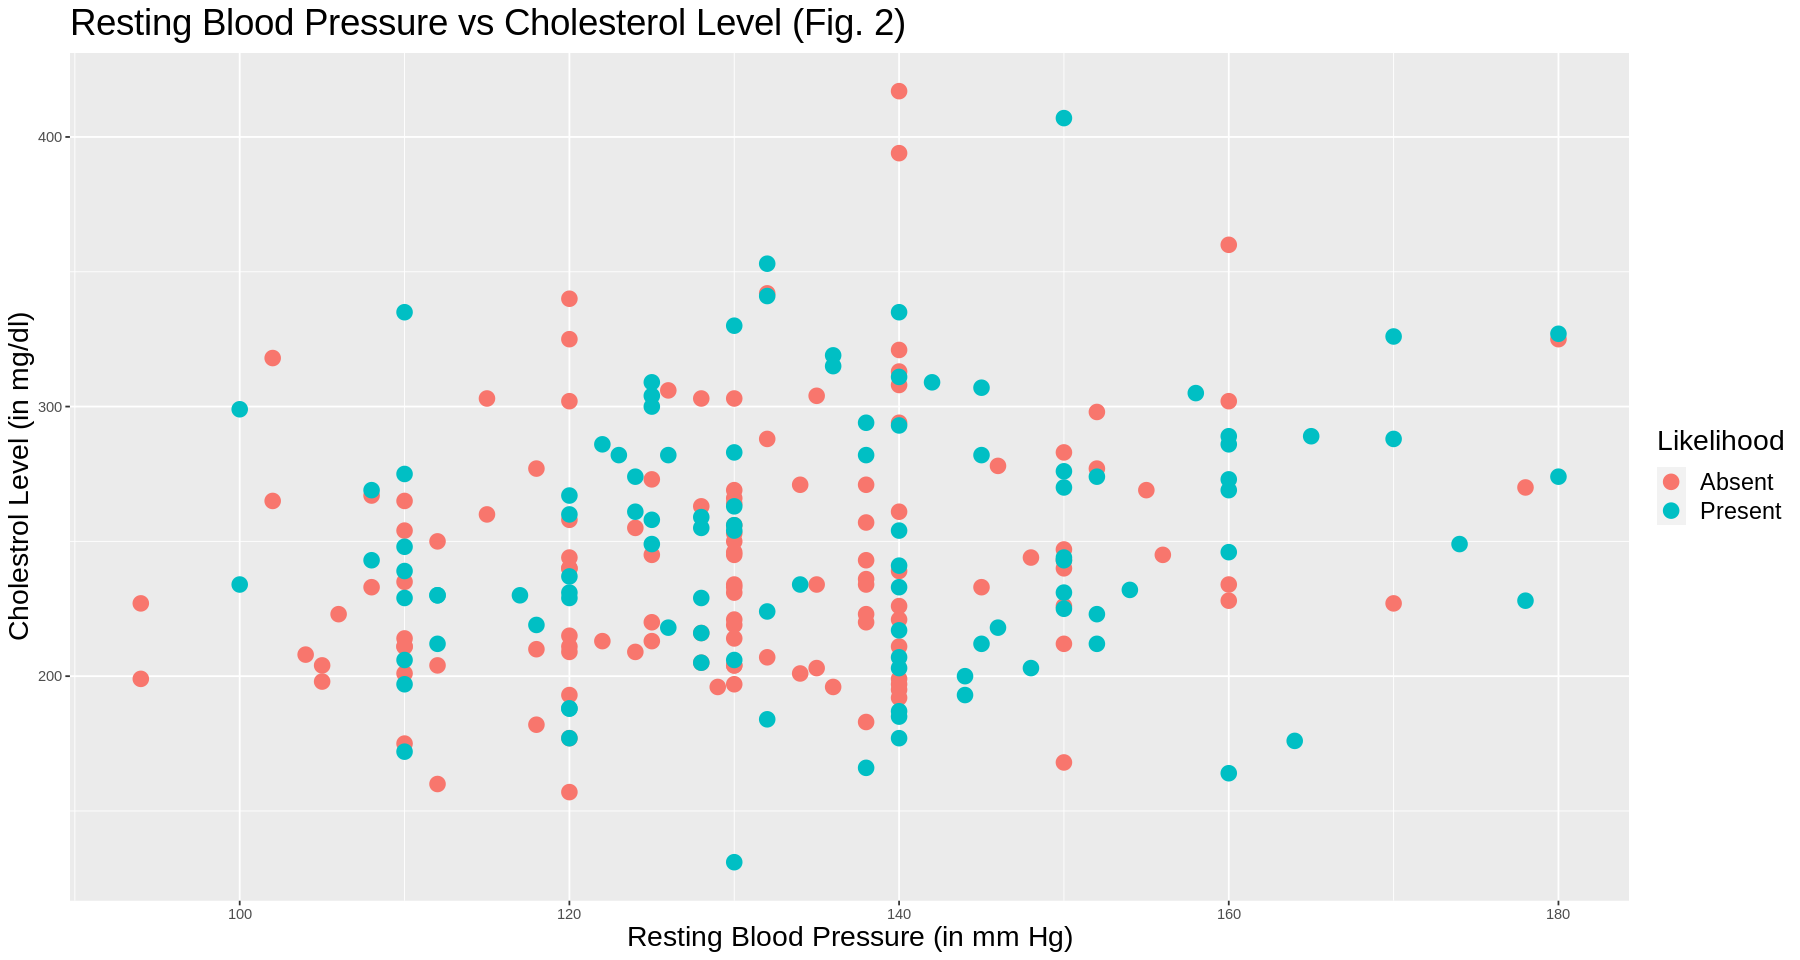

In [22]:
##blood pressure vs Cholestrol Level, coloured by likelihood

bp_v_chol_plot <- data_train |>
                ggplot(aes(x = resting.blood.pressure, y = cholesterol, color = likelihood)) +
                geom_point(size = 4) +
                xlab("Resting Blood Pressure (in mm Hg)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "Likelihood") +
                ggtitle("Resting Blood Pressure vs Cholesterol Level (Fig. 2)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

bp_v_chol_plot

Below is a scatterplot illustrating the relationship between cholestrol level and blood pressure, and whether or not that affects the presence/absence of heart disease. From the graph, we saw no relationship as there was an even distribution of points between the cholesterol and blood pressure. 


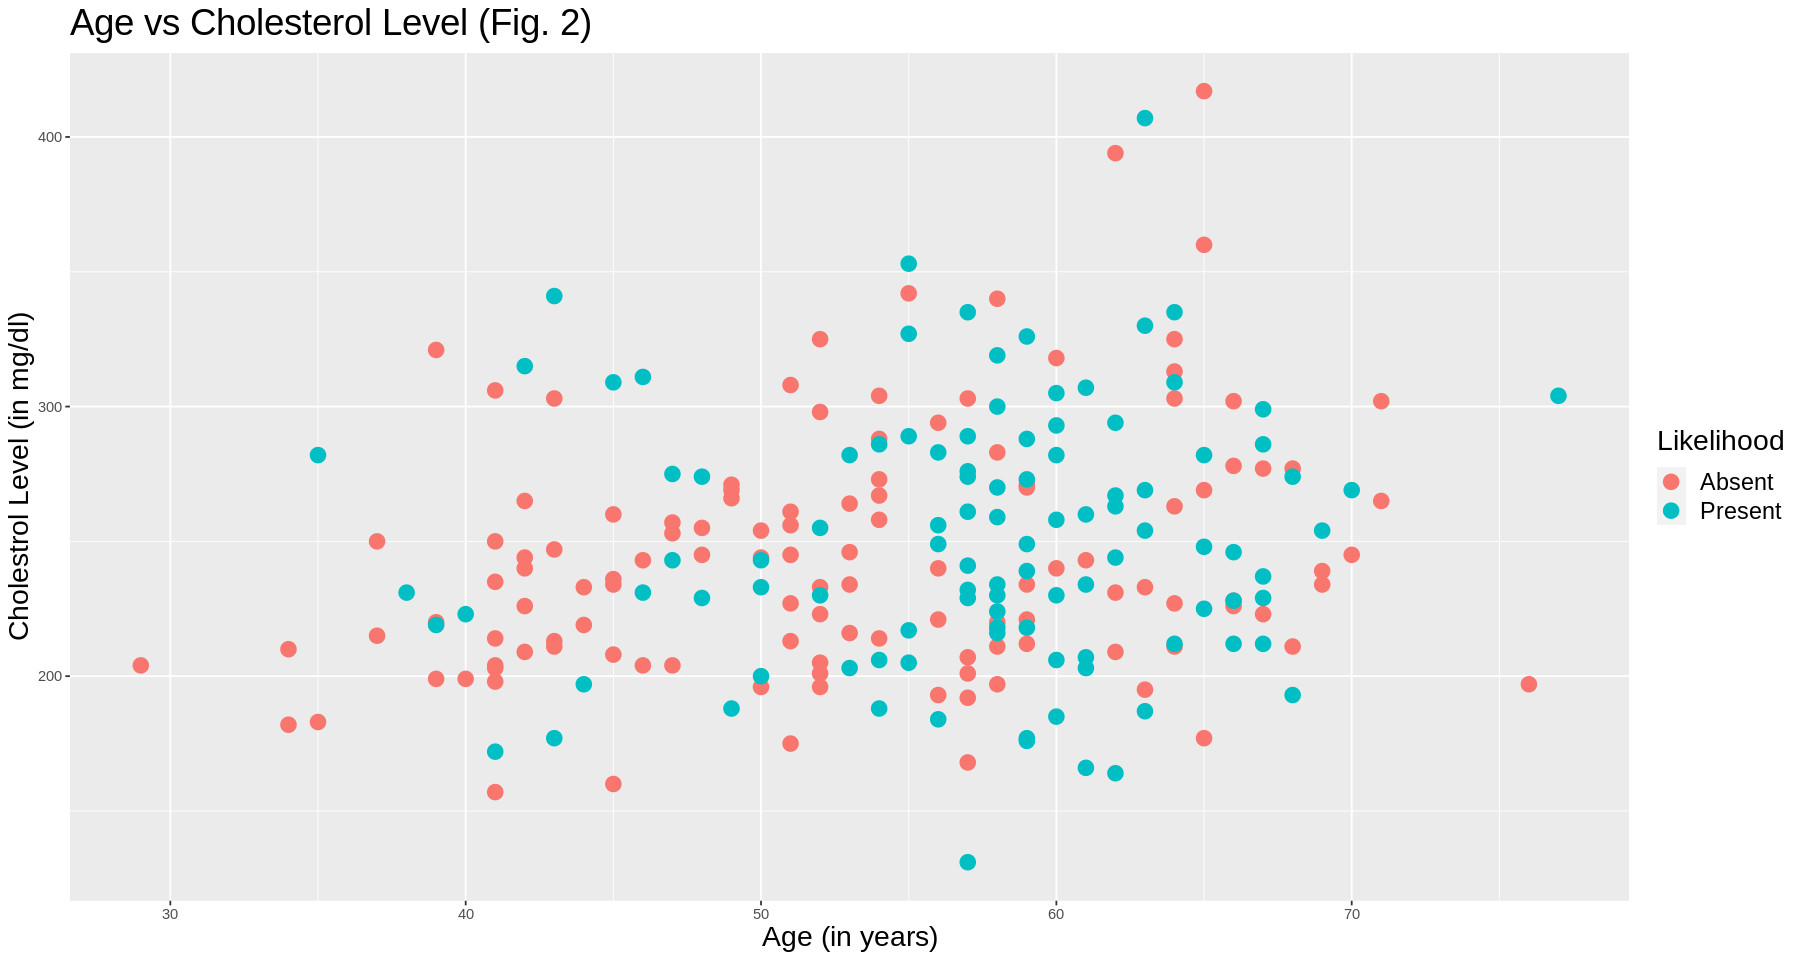

In [23]:
##Age vs Cholestrol Level, coloured by likelihood

age_v_chol_plot <- data_train |>
                ggplot(aes(x = age, y = cholesterol, color = likelihood)) +
                geom_point(size = 4) +
                xlab("Age (in years)") +
                ylab("Cholestrol Level (in mg/dl)") +
                labs(color = "Likelihood") +
                ggtitle("Age vs Cholesterol Level (Fig. 2)") + 
                theme(plot.title = element_text(size=22),
                     axis.title = element_text(size=17),
                     legend.title = element_text(size = 17),
                     legend.text = element_text(size = 14))

age_v_chol_plot


# 3. Methods

Using the Heart Disease dataset provided to us from the UCI Machine Learning Repository, we will use 4 of the variables provided.  They are as follows: age, blood pressure, cholesterol,  and diagnosis of heart disease. From those four variables, we use 3 predictors to see whether or not each data point can be classified as <50% diameter narrowing, which means no risk of heart diseases, or >50% diameter narrowing, which would indicate a severe risk of heart disease. After tidying our data, we will make graphs and colour them based on the two classes(<50% diameter narrowing or >50% diameter narrowing). The raw data consisted of 4 different values. 0 represented an absence of heart disease, and the values 1 2, 3, and 4 represented the presence of heart disease. To create a tidy dataset we mutated 0 to be "Absent" and values between 1-4 to be "Present". Then, when we receive the new data point to classify, we will plot it against the data already present and evaluate the risk of heart disease using the K-nearest neighbors method. 

To help illustrate our observations, we will use scatterplots. In order to ensure that what we are visualizing is clear, we will use markdown cells to describe and clarify.

# 4. Expected Outcomes and Significance 
We expect to find that those with higher cholestrol, high blood pressure and higher age will be at a much higher risk of heart disease than those with the opposite. 

Using these findings, we can encourage people to maintain a healthy lifestyle to preemptively prevent cardiovascular disease. 

In the future, the question that could arise is the proportion to which the genetics and environmental factors have an effect on the probability of getting the disease. 

# 5. Citations

- Centers for Disease Control and Prevention. (2022, September 8). Heart disease and stroke. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm 
- Centers for Disease Control and Prevention. (2021, May 18). High blood pressure symptoms and causes. Centers for Disease Control and Prevention. Retrieved March 2, 2023, from https://www.cdc.gov/bloodpressure/about.htm#:~:text=High%20blood%20pressure%20can%20damage%20your%20arteries%20by%20making%20them,Chest%20pain%2C%20also%20called%20angina 